### Convolution

As mentioned in the previous notebook, `fvdb.nn` contains the `VDBTensor` class and the convolutional layer `SparseConv3d` as well as useful activation functions.

In [1]:
import numpy as np
import torch
import fvdb
import tqdm

from fvdb.nn import VDBTensor, SparseConv3d, LeakyReLU, Sigmoid

batch_size = 8
num_voxels_per_grid = [np.random.randint(1_000, 10_000) for _ in range(batch_size)]

# A list of randomly generated 3D indices for each grid in our batch in the range [-512, 512]
ijks = [torch.randint(-512, 512, (num_voxels_per_grid[i], 3), device="cuda") for i in range(batch_size)]
grid = fvdb.sparse_grid_from_ijk(fvdb.JaggedTensor(ijks))

# Random features
features = grid.jagged_like(torch.randn(grid.total_voxels, 8, device=grid.device))

# VDBTensor
vdbtensor = fvdb.nn.VDBTensor(grid, features)

# SparseConv3d
conv_layer = SparseConv3d(8, 16, kernel_size=3, stride=1).to("cuda")

conv_vdbtensor = conv_layer(vdbtensor)

Convolution on sparse volumes in ƒVDB is similar to the general convolution case on 3D data with one notable difference:  for the `stride=1` case, the topology of the output grid is the same as the input grid.  In effect, we only compute convolution at the active voxel locations in our sparse grid.  The animations below contrast this difference between general convolution and this sparse convolution approach, visualized on 2D grids. (Image Credit:  [Chris Choy](https://chrischoy.github.io/))

<center>

| Dense Convolution | Sparse Convolution 
| :---: | :---: |
| <img src="img/DenseConv.gif" alt="dense" height="350"/>| <img src="img/SparseConv.gif" alt="sparse" height="350"/> |

</center>

This approach is similar to other spatially sparse convolution approaches used in previous works such as [Minkowski Engine](https://github.com/NVIDIA/MinkowskiEngine) and maintains spatial sparsity in the data as we progress through a deep convolutional network.  Using a `stride != 1` (and `stride != kernel_size`) will result in a grid with a different topology where striding has been applied similar to the general, dense convolution case.

See the [Minkowski Engine Documentation](https://nvidia.github.io/MinkowskiEngine/) for deeper discussions on sparse convolution.

Given this feature of sparse 3D convolution, `SparseConv3d` will make sure that the `VDBTensor` which it produces will not unncessarily create new grids for a `GridBatch` if its operation doesn't change the topology of the incoming grids:

In [2]:
# A convolution that does not change the grid's spatial topology
conv_layer = SparseConv3d(8, 16, kernel_size=3, stride=1).to("cuda")

conv_vdbtensor = conv_layer(vdbtensor)

print("Input and output VDBTensor's GridBatches the same: ", VDBTensor.same_grid(vdbtensor.grid, conv_vdbtensor.grid))

Input and output VDBTensor's GridBatches the same:  True


Contrast this with operations which must necessarily create a new grid topology as part of convolving the input, such as when striding over a grid:

In [9]:
# Let's try a convolutional layer that changes the topology of the grid
conv_layer = SparseConv3d(8, 16, stride=4).to("cuda")

conv_vdbtensor = conv_layer(vdbtensor)
print("Input and output VDBTensor's GridBatches the same when toplogy changes: ", VDBTensor.same_grid(vdbtensor.grid, conv_vdbtensor.grid))

Input and output VDBTensor's GridBatches the same when toplogy changes:  False


#### Transposed Convolution

When downsampling a grid, such as in the case above, it is often necessary to upsample the grid by the transposed convolution to produce the same toplogy as the original grid at a later stage in the network.  This often happens in UNet architectures.  

Unlike with dense, general convolution, naive subdivision of the sparse grid we coarsened with strided convolution won't produce the same topology as the original grid.  This is an inherent characteristic of the sparse layout of voxels compared to a dense represenation.

Take a look at the following diagram as an illustration of this point.  In this illustration of a 2D sparse convolution, a 2x2 kernel coarsens the grid to 1 active voxel.  When it is time to perform the tranposed convolution to attempt to invert this operation, it's entirely ambiguous which active voxel contributed to the value at the location of the downsampled grid.

<center>


<img src="img/transposed_sparse_convolution_diagram.svg" alt="dense" height="350"/>

</center>

Any combination of active voxels might be present in the grid we're trying to produce as the inverse of the strided convolution.  To accurately invert a strided convolution, we need to upsample the grid to the original topology by explicitly providing it.

To accomplish this, `SparseConv3d` can be provided the target output grid as an optional argument, `out_grid`, when performing this transpose convolution.

In [10]:
# a transposed convolutional layer
tranpose_conv_layer = SparseConv3d(16, 8, stride=4, transposed=True).to("cuda")

# providing the original grid as the "out_grid" to the transposed convolutional layer
convtransposed_vdbtensor = tranpose_conv_layer(conv_vdbtensor, out_grid=vdbtensor.grid)

print("Convolved grid batch voxel count: ", conv_vdbtensor.total_voxels)
print("Original grid batch voxel count we are required to match: ", vdbtensor.total_voxels)
print("Tranposed convolution grid batch voxel count: ", convtransposed_vdbtensor.total_voxels)

print("Input and tranposed output VDBTensor's GridBatches the same after transpose convolution: ", VDBTensor.same_grid(vdbtensor.grid, convtransposed_vdbtensor.grid))

Convolved grid batch voxel count:  16431
Original grid batch voxel count we are required to match:  39495
Tranposed convolution grid batch voxel count:  39495
Input and tranposed output VDBTensor's GridBatches the same after transpose convolution:  True


If we were to naively do the transposed convolution to a subdivided grid (one that is subdivided twice to try to match the effect of the coarsening we performed with convolution stride=4), this would have most likely given us a grid with a different topology than the original grid with a much larger number of active voxels.

In [17]:
# Let's attempt to do a transposed convolution and output the topology of the convolved grid subdivided twice (to attempt to match the original grid we convolved with stride 4)
convtransposed_vdbtensor = tranpose_conv_layer(conv_vdbtensor, out_grid=conv_vdbtensor.grid.subdivided_grid(3))

print("Total voxel counts")
print("\tOriginal grids: ", vdbtensor.total_voxels)
print("\tConvolved grids: ", conv_vdbtensor.total_voxels)
# this won't match the original grid shape we're after
print("\tTranposed convolution to grids subdivided twice: ", convtransposed_vdbtensor.total_voxels)


Total voxel counts
	Original grids:  39495
	Convolved grids:  16431
	Tranposed convolution to grids subdivided twice:  443637


#### Simple UNet

Now that we understand the basics of convolution, concatenation and training networks with ƒVDB, let's write a simple UNet architecture to segment randomly placed sphere shapes from 3D grids of spheres and noise.

In [45]:
# DataSet that produces random grids centered at 0, 0, 0 worldspace with voxel sizes (0.01, 0.01, 0.01)
from torch.utils.data import Dataset


class RandomSpheresDataset(Dataset):
    def __init__(self, batch_size):
        self.batch_size = batch_size

    def __len__(self):
        return 100

    def __getitem__(self, idx) -> VDBTensor:
        ijks = [torch.randint(-100, 100, (np.random.randint(1_000, 5_000), 3), device="cuda") for i in range(self.batch_size)]
        grid = fvdb.sparse_grid_from_ijk(fvdb.JaggedTensor(ijks), voxel_sizes=0.01)
        # random sphere
        sphere_radius = 0.9
        rand_sphere_origin = torch.rand(3, device=grid.device) - 0.5
        # distance from the the sphere origin
        points = grid.grid_to_world(grid.ijk.float()).jdata
        dist = torch.sqrt(torch.sum((points - rand_sphere_origin) ** 2, dim=1))

        target = (dist < sphere_radius)[:, None]

        # add noise to target
        features = target.float() + torch.empty(target.shape, device=target.device).normal_()
        features = torch.cat([features, points], dim=1)
        return VDBTensor(grid, grid.jagged_like(features)), target

In [46]:
# Define model
import functools

ConvClass = functools.partial(SparseConv3d, kernel_size=3, bias=False)
class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        channels = 16
        depth = 0

        self.conv0_0 = ConvClass(4, channels * 2 ** (depth + 1))
        self.conv0_1 = ConvClass(channels * 2 ** (depth + 1), channels * 2 ** (depth + 1))

        depth += 1
        self.conv1_0 = ConvClass(channels * 2 ** (depth), channels * 2 ** (depth + 1), stride=2)
        self.conv1_1 = ConvClass(channels * 2 ** (depth + 1), channels * 2 ** (depth + 1))

        depth += 1
        self.conv2_0 = ConvClass(channels * 2 ** (depth), channels * 2 ** (depth + 1), stride=2)
        self.conv2_1 = ConvClass(channels * 2 ** (depth + 1), channels * 2 ** (depth + 1))

        depth += 1
        self.conv3_0 = ConvClass(channels * 2 ** (depth), channels * 2 ** (depth + 1), stride=2)
        self.conv3_1 = ConvClass(channels * 2 ** (depth + 1), channels * 2 ** (depth + 1))

        depth += 1
        self.conv4_0 = ConvClass(channels * 2 ** (depth), channels * 2 ** (depth + 1), stride=2)
        self.conv4_1 = ConvClass(channels * 2 ** (depth + 1), channels * 2 ** (depth + 1))

        depth -= 1
        self.dconv3_0 = ConvClass(channels * 2 ** (depth + 2), channels * 2 ** (depth + 1), stride=2, transposed=True)
        self.dconv3_1 = ConvClass(channels * 2 ** (depth + 2), channels * 2 ** (depth + 1))
        self.dconv3_2 = ConvClass(channels * 2 ** (depth + 1), channels * 2 ** (depth + 1))

        depth -= 1
        self.dconv2_0 = ConvClass(channels * 2 ** (depth + 2), channels * 2 ** (depth + 1), stride=2, transposed=True)
        self.dconv2_1 = ConvClass(channels * 2 ** (depth + 2), channels * 2 ** (depth + 1))
        self.dconv2_2 = ConvClass(channels * 2 ** (depth + 1), channels * 2 ** (depth + 1))

        depth -= 1
        self.dconv1_0 = ConvClass(channels * 2 ** (depth + 2), channels * 2 ** (depth + 1), stride=2, transposed=True)
        self.dconv1_1 = ConvClass(channels * 2 ** (depth + 2), channels * 2 ** (depth + 1))
        self.dconv1_2 = ConvClass(channels * 2 ** (depth + 1), channels * 2 ** (depth + 1))

        depth -= 1
        self.dconv0_0 = ConvClass(channels * 2 ** (depth + 2), channels * 2 ** (depth + 1), stride=2, transposed=True)
        self.dconv0_1 = ConvClass(channels * 2 ** (depth + 2), channels * 2 ** (depth + 1))
        self.dconv0_2 = ConvClass(channels * 2 ** (depth + 1), channels * 2 ** (depth + 1))
        self.output = SparseConv3d(channels * 2 ** (depth + 1), 1, kernel_size=1, bias=False)

        self.relu = LeakyReLU()
        self.sigmoid = Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv0_0(x))
        conv0_output = self.relu(self.conv0_1(x))

        x = self.relu(self.conv1_0(conv0_output))
        conv1_output = self.relu(self.conv1_1(x))

        x = self.relu(self.conv2_0(conv1_output))
        conv2_output = self.relu(self.conv2_1(x))

        x = self.relu(self.conv3_0(x))
        conv3_output = self.relu(self.conv3_1(x))

        x = self.relu(self.conv4_0(x))
        x = self.relu(self.conv4_1(x))

        x = self.relu(self.dconv3_0(x, out_grid=conv3_output.grid))
        x = VDBTensor.cat([x, conv3_output], dim=1)
        x = self.relu(self.dconv3_1(x))
        x = self.relu(self.dconv3_2(x))

        x = self.relu(self.dconv2_0(x, out_grid=conv2_output.grid))
        x = VDBTensor.cat([x, conv2_output], dim=1)
        x = self.relu(self.dconv2_1(x))
        x = self.relu(self.dconv2_2(x))

        x = self.relu(self.dconv1_0(x, out_grid=conv1_output.grid))
        x = VDBTensor.cat([x, conv1_output], dim=1)
        x = self.relu(self.dconv1_1(x))
        x = self.relu(self.dconv1_2(x))

        x = self.relu(self.dconv0_0(x, out_grid=conv0_output.grid))
        x = VDBTensor.cat([x, conv0_output], dim=1)
        x = self.relu(self.dconv0_1(x))
        x = self.relu(self.dconv0_2(x))
        x = self.output(x)
        x = self.sigmoid(x)
        return x


# Data
dataset = RandomSpheresDataset(batch_size)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, collate_fn=lambda x: x[0])

# Model, Loss, Optimizer
model = UNet().to("cuda")
loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

epochs = 50
with tqdm.tqdm(total=epochs) as pbar:
    for epoch in range(epochs):
        for i, (data, target) in enumerate(dataloader):
            optimizer.zero_grad()
            output = model(data)
            l = loss(output.feature.jdata, target.float())
            l.backward()
            optimizer.step()
            pbar.set_description(f"Epoch {epoch}, batch {i}, loss {l.item()}")
        pbar.update(1)

Epoch 49, batch 99, loss 0.11100000888109207: 100%|██████████| 50/50 [47:07<00:00, 56.56s/it]


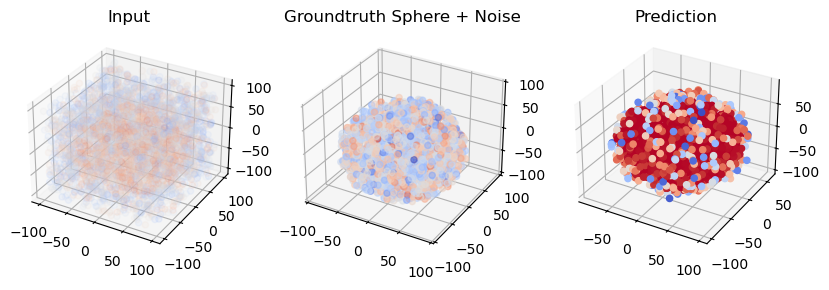

In [61]:
# Visualize the results of the trained network

import matplotlib.pyplot as plt


X, gt = next(iter(dataloader))

fig = plt.figure(figsize=(10, 20))

X_ijks_0 = X.grid.ijk.jdata[X.grid.jidx == 0].detach().cpu().numpy()
X_feats_0 = X.feature.jdata[X.grid.jidx == 0][:, 0].detach().cpu().numpy()
X_gt_0 = gt[X.grid.jidx == 0].detach().cpu().numpy()
X_gt_ijks_0 = X_ijks_0[X_gt_0[:, 0] == 1]
X_gt_feats_0 = X_feats_0[X_gt_0[:, 0] == 1]


# plot input features
ax = fig.add_subplot(1, 3, 1, projection="3d")
ax.scatter3D(X_ijks_0[:, 0], X_ijks_0[:, 1], X_ijks_0[:, 2], marker="o", c=X_feats_0, cmap="coolwarm", alpha=0.1)
ax.set_title("Input")

# plot groundtruth
ax = fig.add_subplot(1, 3, 2, projection="3d")
dim = 100
ax.set_xlim(-dim, dim)
ax.set_ylim(-dim, dim)
ax.set_zlim(-dim, dim)
ax.scatter3D(X_gt_ijks_0[:, 0], X_gt_ijks_0[:, 1], X_gt_ijks_0[:, 2], marker="o", c=X_gt_feats_0, alpha=0.5, cmap="coolwarm")
ax.set_title("Groundtruth Sphere + Noise")

model.eval()
pred = model(X)

pred_0 = pred.feature.jdata[pred.grid.jidx == 0].detach().cpu().numpy()

ijks_pred_0 = X_ijks_0[np.round(pred_0)[:, 0] == 1]
feats_pred_0 = pred_0[np.round(pred_0)[:, 0] == 1]

ax = fig.add_subplot(1, 3, 3, projection="3d")
ax.scatter3D(ijks_pred_0[:, 0], ijks_pred_0[:, 1], ijks_pred_0[:, 2], marker="o", c=feats_pred_0, cmap="coolwarm", alpha=1)
ax.set_title("Prediction w/Probabilities")


fig.show()